# Expedia Hotel Recommendations

## 1. Цель
Суть задачи - научиться предсказывать какой из 100 *hotel_cluster* забронирует пользователь после поиска по сайту с определенными параметрами (дата вылета, страна, город, кол-во взрослых и детских мест и т.д.). Оцениваться точность проноза будет с использованием **Mean Average Precision @ 5**. Это значит, что для каждой строки мы должны спрогнозировать набор, состоящий из 5 кластеров, и в случае, если один из них окажется верным, мы получим определенное количество очков. При этом, вес у элементов из набора убывает, и мы получим тем больше очков, чем раньше мы укажем правильный кластер в наборе.

## 2. Контекст

In [2]:
from IPython.display import IFrame
IFrame('https://www.expedia.com', width=900, height=700)

## 3. Данные

### 3.1 Overview

Большинство значений это целочисленный тип, что затрудняет создание новых признаков:

In [37]:
import pandas as pd

destinations = pd.read_csv("destinations.csv")
test = pd.read_csv("test.csv")
train = pd.read_csv("train.csv")

In [2]:
train.head(1)

,date_time,site_name,posa_continent,user_location_country,user_location_region,user_location_city,orig_destination_distance,user_id,is_mobile,is_package,...,srch_children_cnt,srch_rm_cnt,srch_destination_id,srch_destination_type_id,is_booking,cnt,hotel_continent,hotel_country,hotel_market,hotel_cluster
0,2014-08-11 07:46:59,2,3,66,348,48862,2234.2641,12,0,1,...,0,1,8250,1,0,3,2,50,628,1


In [3]:
test.head(1)

,id,date_time,site_name,posa_continent,user_location_country,user_location_region,user_location_city,orig_destination_distance,user_id,is_mobile,...,srch_ci,srch_co,srch_adults_cnt,srch_children_cnt,srch_rm_cnt,srch_destination_id,srch_destination_type_id,hotel_continent,hotel_country,hotel_market
0,0,2015-09-03 17:09:54,2,3,66,174,37449,5539.0567,1,1,...,2016-05-19,2016-05-23,2,0,1,12243,6,6,204,27


Примерно 38 млн. записей в trainnig set-e и 2 млн. записей в test set-e:

In [4]:
train.shape

(37670293, 24)

In [5]:
test.shape

(2528243, 22)

Будет полезным конвертировать date_time поле в соответствующий тип и добавить на его основе поля year и month:

In [38]:
train["date_time"] = pd.to_datetime(train["date_time"])
train["year"] = train["date_time"].dt.year
train["month"] = train["date_time"].dt.month

In [39]:
test["date_time"] = pd.to_datetime(test["date_time"])
test["year"] = test["date_time"].dt.year
test["month"] = test["date_time"].dt.month

Данные в тестовом сете взяты из более свежего периода (2015 год), нежели данные из train.csv (2013-2014 года):

In [44]:
train.year.unique()

array([2014, 2013])

In [43]:
test.year.unique()

array([2015])

UserID из test set-a является подмножеством UserID из train set-a:

In [42]:
test_ids = set(test.user_id.unique())
train_ids = set(train.user_id.unique())
intersection_count = len(test_ids & train_ids)
intersection_count == len(test_ids)

True

Распределение количества запросов поиска по кластерам выглядит нормальным:

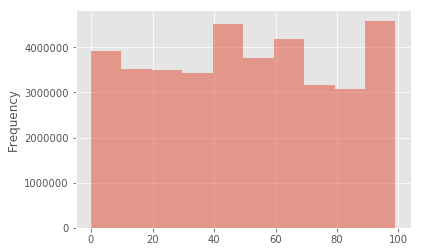

In [29]:
import matplotlib
matplotlib.pyplot.figure()
train["hotel_cluster"].plot.hist(alpha=0.5)
matplotlib.pyplot.show()

Отсутствует значимая линейная корреляция между каким-либо из признаков и hotel_cluster, следовательно, использовать линейную или логистическую регрессию не имеет особого смысла:

In [27]:
train.corr()["hotel_cluster"]

site_name                   -0.022408
posa_continent               0.014938
user_location_country       -0.010477
user_location_region         0.007453
user_location_city           0.000831
orig_destination_distance    0.007260
user_id                      0.001052
is_mobile                    0.008412
is_package                   0.038733
channel                      0.000707
srch_adults_cnt              0.012309
srch_children_cnt            0.016261
srch_rm_cnt                 -0.005954
srch_destination_id         -0.011712
srch_destination_type_id    -0.032850
is_booking                  -0.021548
cnt                          0.002944
hotel_continent             -0.013963
hotel_country               -0.024289
hotel_market                 0.034205
hotel_cluster                1.000000
year                        -0.001050
month                       -0.000560
Name: hotel_cluster, dtype: float64

## 4. Форум

На форуме был найден интересный "хинт". Примерно 1/3 данных легко восстанавливаются по полям user_id, user_location_country, user_location_region, user_location_city, hotel_market и orig_destination_distance